In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import BernoulliRBM
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [6]:
data = pd.read_csv("bank-full.csv", sep=';')
data = pd.get_dummies(data, drop_first=True)  
X = data.drop(columns=['y_yes'])  
y = data['y_yes']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Normalization (for RBM)
min_max_scaler = MinMaxScaler()
X_normalized = min_max_scaler.fit_transform(X)
X_bin = np.where(X_normalized > 0.5, 1, 0)
X_train_bin, X_test_bin, y_train, y_test = train_test_split(X_bin, y, test_size=0.2, random_state=42)



In [7]:
pca = PCA(n_components=0.95)  # Keeps 95% variance
X_train_pca = pca.fit_transform(X_train_bin)
X_test_pca = pca.transform(X_test_bin)

In [8]:
from scipy.special import expit  
components_list = [100, 150, 200]
learning_rates = [0.01, 0.05]
n_iters = [10, 15]

print(" RBM hyperparameter tuning based on reconstruction error:")
best_score = float('inf')
best_params = {}
best_rbm_model = None

for n_comp in components_list:
    for lr in learning_rates:
        for n_iter in n_iters:
            rbm = BernoulliRBM(n_components=n_comp, learning_rate=lr, n_iter=n_iter, random_state=42, verbose=False)
            rbm.fit(X_train_bin)

            # Transform and reconstruct
            X_hidden = rbm.transform(X_train_bin)
            X_recon = expit(np.dot(X_hidden, rbm.components_))  # reconstruction

            recon_error = np.mean(np.square(X_train_bin - X_recon))
            print(f"n_components={n_comp}, lr={lr}, n_iter={n_iter} → Recon error: {recon_error:.4f}")

            if recon_error < best_score:
                best_score = recon_error
                best_params = {'n_components': n_comp, 'learning_rate': lr, 'n_iter': n_iter}
                best_rbm_model = rbm

print("\nBest RBM Params:")
print(best_params)
print(f"Best reconstruction error: {best_score:.4f}")

 RBM hyperparameter tuning based on reconstruction error:
n_components=100, lr=0.01, n_iter=10 → Recon error: 0.0305
n_components=100, lr=0.01, n_iter=15 → Recon error: 0.0239
n_components=100, lr=0.05, n_iter=10 → Recon error: 0.0152
n_components=100, lr=0.05, n_iter=15 → Recon error: 0.0147
n_components=150, lr=0.01, n_iter=10 → Recon error: 0.0282
n_components=150, lr=0.01, n_iter=15 → Recon error: 0.0220
n_components=150, lr=0.05, n_iter=10 → Recon error: 0.0150
n_components=150, lr=0.05, n_iter=15 → Recon error: 0.0153
n_components=200, lr=0.01, n_iter=10 → Recon error: 0.0265
n_components=200, lr=0.01, n_iter=15 → Recon error: 0.0207
n_components=200, lr=0.05, n_iter=10 → Recon error: 0.0163
n_components=200, lr=0.05, n_iter=15 → Recon error: 0.0173

Best RBM Params:
{'n_components': 100, 'learning_rate': 0.05, 'n_iter': 15}
Best reconstruction error: 0.0147


In [9]:
X_train_rbm = best_rbm_model.transform(X_train_bin)
X_test_rbm = best_rbm_model.transform(X_test_bin)

In [12]:
clf_orig = LogisticRegression()
clf_pca = LogisticRegression()
clf_rbm = MLPClassifier(hidden_layer_sizes=(20,), max_iter=300, random_state=42)  # Using Neural Network for RBM

clf_orig.fit(X_train_bin, y_train)
clf_pca.fit(X_train_pca, y_train)
clf_rbm.fit(X_train_rbm, y_train)

y_pred_orig = clf_orig.predict(X_test_bin)
y_pred_pca = clf_pca.predict(X_test_pca)
y_pred_rbm = clf_rbm.predict(X_test_rbm)

In [13]:
print("Original Data - Logistic Regression:")
print(classification_report(y_test, y_pred_orig))
print("PCA Data - Logistic Regression:")
print(classification_report(y_test, y_pred_pca))
print("RBM Data - Neural Network:")
print(classification_report(y_test, y_pred_rbm))

Original Data - Logistic Regression:
              precision    recall  f1-score   support

       False       0.90      0.99      0.94      7952
        True       0.66      0.18      0.29      1091

    accuracy                           0.89      9043
   macro avg       0.78      0.59      0.61      9043
weighted avg       0.87      0.89      0.86      9043

PCA Data - Logistic Regression:
              precision    recall  f1-score   support

       False       0.89      0.99      0.94      7952
        True       0.73      0.14      0.24      1091

    accuracy                           0.89      9043
   macro avg       0.81      0.57      0.59      9043
weighted avg       0.87      0.89      0.86      9043

RBM Data - Neural Network:
              precision    recall  f1-score   support

       False       0.90      0.98      0.94      7952
        True       0.63      0.21      0.31      1091

    accuracy                           0.89      9043
   macro avg       0.77      0.6

In [ ]:
joblib.dump(scaler, "scaler.pkl")
joblib.dump(min_max_scaler, "min_max_scaler.pkl")
joblib.dump(pca, "pca.pkl")
joblib.dump(rbm, "rbm.pkl")
joblib.dump(clf_orig, "clf_orig.pkl")
joblib.dump(clf_pca, "clf_pca.pkl")
joblib.dump(clf_rbm, "clf_rbm.pkl")

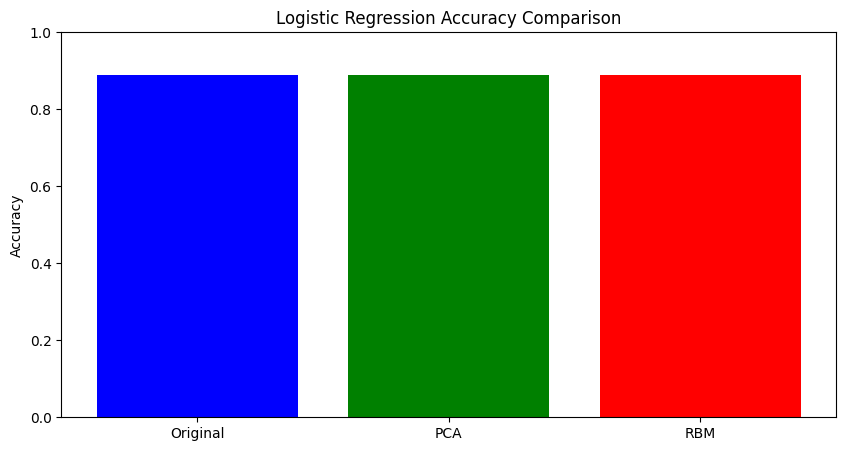

In [14]:
orig_acc = accuracy_score(y_test, y_pred_orig)
pca_acc = accuracy_score(y_test, y_pred_pca)
rbm_acc = accuracy_score(y_test, y_pred_rbm)

plt.figure(figsize=(10,5))
plt.bar(["Original", "PCA", "RBM"], [orig_acc, pca_acc, rbm_acc], color=["blue", "green", "red"])
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Logistic Regression Accuracy Comparison")
plt.show()

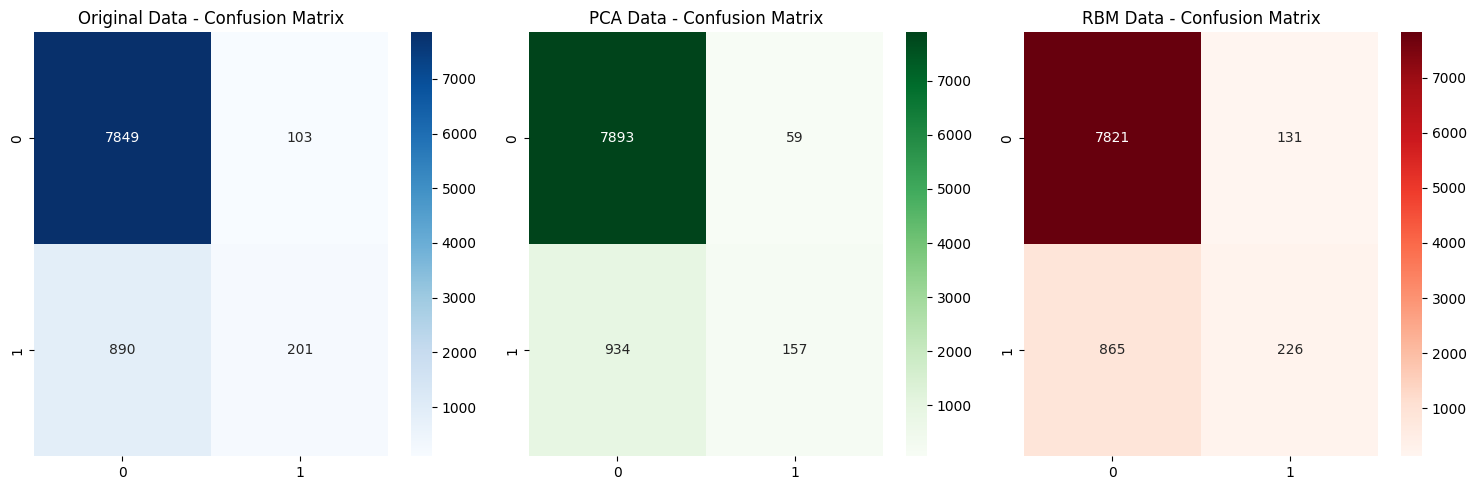

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(confusion_matrix(y_test, y_pred_orig), annot=True, fmt='d', ax=axes[0], cmap="Blues")
axes[0].set_title("Original Data - Confusion Matrix")

sns.heatmap(confusion_matrix(y_test, y_pred_pca), annot=True, fmt='d', ax=axes[1], cmap="Greens")
axes[1].set_title("PCA Data - Confusion Matrix")

sns.heatmap(confusion_matrix(y_test, y_pred_rbm), annot=True, fmt='d', ax=axes[2], cmap="Reds")
axes[2].set_title("RBM Data - Confusion Matrix")

plt.tight_layout()
plt.show()

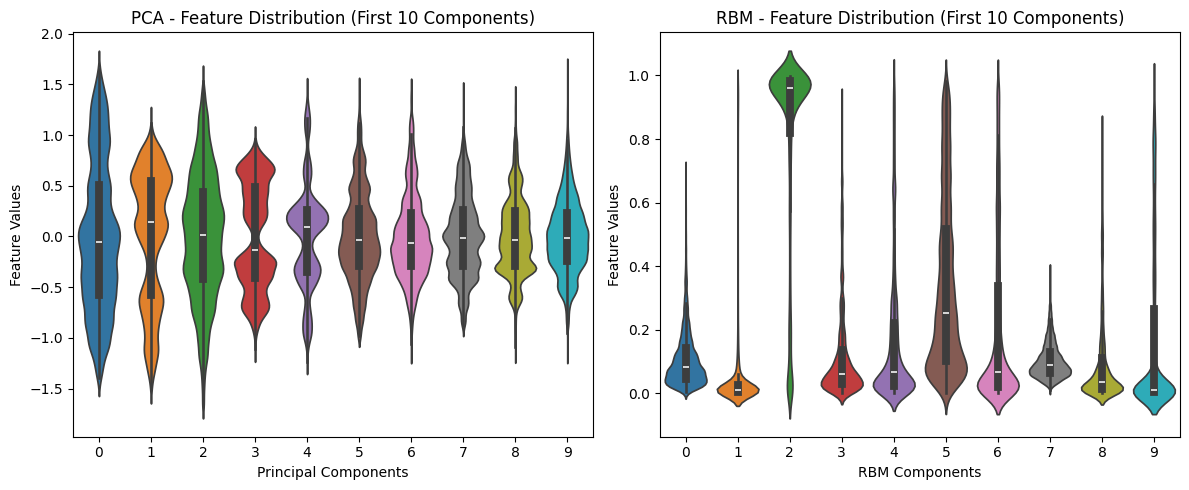

In [16]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
X_sample_pca = pd.DataFrame(X_train_pca[:, :10])  # Take only first 10 components
sns.violinplot(data=X_sample_pca)  # Violin plot is memory efficient
plt.title("PCA - Feature Distribution (First 10 Components)")
plt.xlabel("Principal Components")
plt.ylabel("Feature Values")

plt.subplot(1, 2, 2)
X_sample_rbm = pd.DataFrame(X_train_rbm[:, :10])  # Take only first 10 components
sns.violinplot(data=X_sample_rbm)
plt.title("RBM - Feature Distribution (First 10 Components)")
plt.xlabel("RBM Components")
plt.ylabel("Feature Values")

plt.tight_layout()
plt.show()


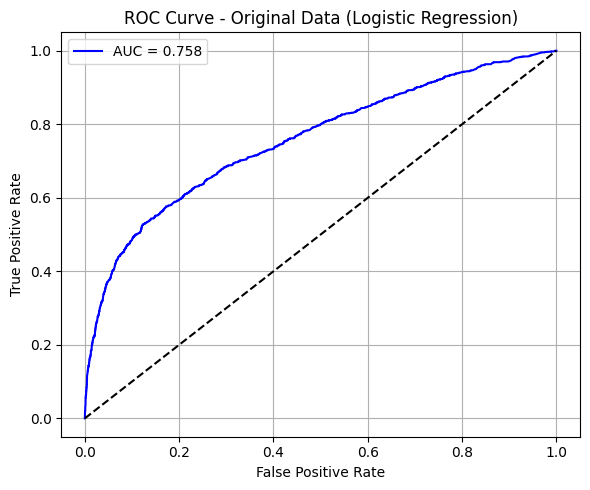

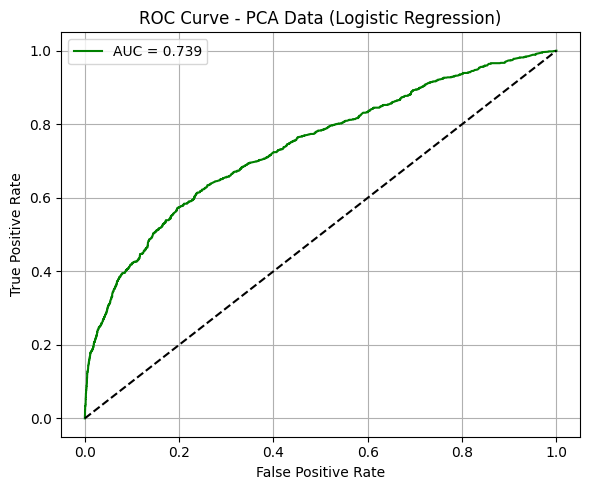

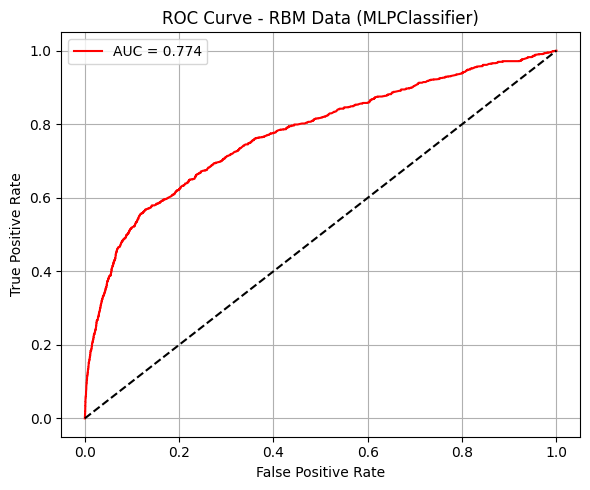

In [18]:
from sklearn.metrics import roc_curve, roc_auc_score

# Predict probabilities for each model
y_proba_orig = clf_orig.predict_proba(X_test_bin)[:, 1]
y_proba_pca = clf_pca.predict_proba(X_test_pca)[:, 1]
y_proba_rbm = clf_rbm.predict_proba(X_test_rbm)[:, 1]

# ========== ROC for Original Data ==========
fpr_orig, tpr_orig, _ = roc_curve(y_test, y_proba_orig)
auc_orig = roc_auc_score(y_test, y_proba_orig)

plt.figure(figsize=(6, 5))
plt.plot(fpr_orig, tpr_orig, label=f"AUC = {auc_orig:.3f}", color="blue")
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve - Original Data (Logistic Regression)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ========== ROC for PCA Data ==========
fpr_pca, tpr_pca, _ = roc_curve(y_test, y_proba_pca)
auc_pca = roc_auc_score(y_test, y_proba_pca)

plt.figure(figsize=(6, 5))
plt.plot(fpr_pca, tpr_pca, label=f"AUC = {auc_pca:.3f}", color="green")
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve - PCA Data (Logistic Regression)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ========== ROC for RBM Data ==========
fpr_rbm, tpr_rbm, _ = roc_curve(y_test, y_proba_rbm)
auc_rbm = roc_auc_score(y_test, y_proba_rbm)

plt.figure(figsize=(6, 5))
plt.plot(fpr_rbm, tpr_rbm, label=f"AUC = {auc_rbm:.3f}", color="red")
plt.plot([0, 1], [0, 1], "k--")
plt.title("ROC Curve - RBM Data (MLPClassifier)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
